# Machine Learning for Time Series Analysis

I recommend using venv to set up virtual environments. These are isolated Python installations and then you won't run into conflicts there.

To setup, type "python3 -m venv <envname>". To activate type ". <envname>/bin/activate" (the "." reads the contents into the shell which sets up the proper environment variables.) If you want to leave type "deactivate".

Now we want to use general machine learning algorithms on the data. We will use scikit-learn, which is the de fact standard for general machine learning.

Prior to running this, install slearn, numpy, and matplotlib. To see this notebook, install jupyter. Then, go to this directory and type "jupyter notebook" and you can open the notebook.

Execute lines by shift+Return.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Generate some toy data

Let us first generate some toy data. We again use the arma process sample.

The reader is encouraged to try these methods on more "interesting" data!

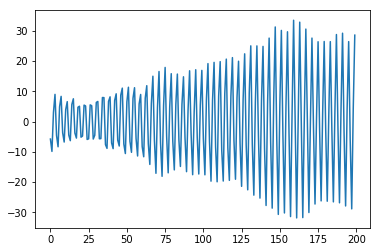

In [26]:
from statsmodels.tsa.arima_process import arma_generate_sample
xs = arma_generate_sample([1.0, -0.6, 1.0, -0.6], [1.0], 200, 1.0, burnin=100)
plt.plot(xs)

## Helper function to embed data (only works for 1d data)

The first step is to transform the time series prediction problem into a supervised learning problem. For this, the previous values used for prediction are extracted for each time step. These become then the input-output pairs.

The following helper function accomplishes that. Note that it assumes that x is one-dimensional. For multivariate time series, which can also be treated in this way, the function needs to be modified.

In [3]:
def embed_data(x, steps):
    n = len(x)
    xout = np.zeros((n - steps, steps))
    yout = x[steps:]
    for i in np.arange(steps, n):
        xout[i - steps] = x[i-steps:i]
    return xout, yout

x, y = embed_data(np.array([1,2,3,4,5]), 2)

Let's try it on a bit of data to see whether it works (it does).

In [4]:
x, y

(array([[ 1.,  2.],
        [ 2.,  3.],
        [ 3.,  4.]]), array([3, 4, 5]))

## Train a support vector regression on this

Let us train a Support Vector Regression learner on this. This is a general purpose algorithm which is implemented in a very efficient manner. Depending on the kernel, the resulting model is linear or non-linear.

This is a pretty reduced set-up in a real setting, you would want to set up cross-validation to estimate the right choices for the learned model.

We will do a proper training and test split a bit further below, however.

In [5]:
import sklearn
from sklearn import svm

scikit-learn's interface works like this:
  1. construct the model my creating an instance of the corresponding class, setting parameters
  2. fitting the model with the fit() function, passing in input and output as two separate arrays.
  3. using the model's predict() function, you can compute on new data points.
  
In summary, unlike in statsmodel, the model object is the same, there is no separate result object.

In [6]:
model = svm.SVR(kernel='linear', C=1)

Let us train this on the very simple data set from above.

In [7]:
model.fit(x, y)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Predicting on the training points should return very good results, and in fact, does.

In [8]:
model.predict(x)

array([ 3.1,  4. ,  4.9])

So far, so good. Now let us apply this to the toy data above which was sampled from the ARMA process. We use the embedding function, and embed with order 5.

In [9]:
x, y = embed_data(xs, 5)

In [10]:
model.fit(x, y)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Let us now plot the predicted values vs. the true values. If the prediction were perfect, we would see a perfect diagonal line, but due to noise, we will often see something else. This kind of plot is also great for identifying whether the errors are uniform over all ranges, or whether there are some areas which have higher variance than others. This plot also work irrespective of the input dimensionality.

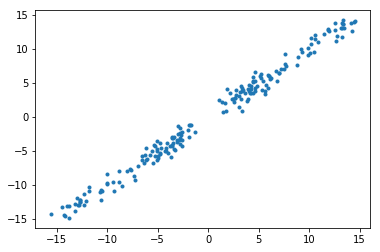

In [11]:
plt.plot(model.predict(x), y, '.')

To properly evaluate, let us use one of the metrics functions from scikit-learn, namely the mean squared error.

In [12]:
from sklearn import metrics

In [13]:
metrics.mean_squared_error(model.predict(x), y)

0.83496325733424082

I personally like to divide this error by the squared norm of y to get the ratio of the total variance reduced.

In [14]:
np.linalg.norm(model.predict(x) - y)**2 / np.linalg.norm(y)**2

0.0131435273017534

## Using proper training and test splits

Now again, let us see how we perform on a true test set. scikit-learn has functions for properly splitting time series data in package sklearn.model_selection.TimeSeriesSplit, but here, we will do the split by hand.

In [27]:
train = xs[:150]
test = xs[150:]
xtrain, ytrain = embed_data(train, 3)
xtest, ytest = embed_data(test, 3)

Now, train again the SVR only on the training data. I have chosen an rbf kernel now, just to see how that performs.

In [28]:
m = svm.SVR(kernel='rbf', C=1, gamma=0.1)
m.fit(xtrain, ytrain)

SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Let us plot the fit on the training data, which should be quite good.

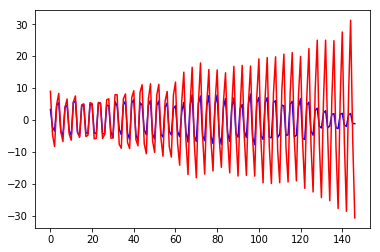

In [30]:
plt.plot(m.predict(xtrain), 'b-', ytrain, 'r-')

And now the predictions on the test data.

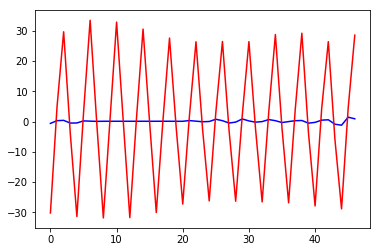

In [29]:
plt.plot(m.predict(xtest), 'b-', ytest, 'r-')

The outcome depends a bit on the random data that was initially drawn, but often you will see that the data tapers off to zero. The reason for this is that the rbf kernel is actually sensitive to the scale of the data, and if the test data is for some reason of higher variance than the training data, the SVR will predict too small values there and the preditions will go to zero.

This code is the basic steps to go through, to explore further,
  * use a more interesting data source
  * experiment with using different kernels or learners (like decision trees for regression, random forests, etc.)